## 전국 신규 민간 아파트 분양가격 동향

공공데이터를 활용하여 pandas의 groupby와 pivot_table 그외 시각화 방법으로 지역별 및 연도별 아파트 분양가 분석 

* 데이터  다운로드 수집 
 : https://www.data.go.kr/data/15061057/fileData.do

In [1]:
import numpy as np
import pandas as pd 
# 최근 분양가 파일을 로드해서 df_last 라는 변수에 담습니다.
# 파일로드시 OSError가 발생한다면, engine="python"을 추가해 보세요.
df_last = pd.read_csv("./주택도시보증공사_전국 신규 민간아파트 분양가격 동향_20240731.csv", encoding="cp949", engine="python")
df_last.shape

(9010, 5)

In [2]:
# head 로 파일을 미리보기 합니다.

df_last.head()

,지역명,규모구분,연도,월,분양가격(제곱미터)
0,서울,모든면적,2015,10,5841
1,서울,전용면적 60제곱미터이하,2015,10,5652
2,서울,전용면적 60제곱미터초과 85제곱미터이하,2015,10,5882
3,서울,전용면적 85제곱미터초과 102제곱미터이하,2015,10,5721
4,서울,전용면적 102제곱미터초과,2015,10,5879


### 데이터 타입 변경
분양가격이 object(문자) 타입으로 되어 있습니다. 문자열 타입을 계산할 수 없기 때문에 수치 데이터로 변경해 줍니다. 결측치가 섞여 있을 때 변환이 제대로 되지 않습니다. 그래서 pd.to_numeric 을 통해 데이터의 타입을 변경합니다.

In [5]:
df_last["분양가격"] = pd.to_numeric(df_last["분양가격(제곱미터)"], errors='coerce')
df_last["분양가격"].head()

0    5841.0
1    5652.0
2    5882.0
3    5721.0
4    5879.0
Name: 분양가격, dtype: float64

### 평당분양가격 구하기

공공데이터포털에 올라와 있는 2013년부터의 데이터는 평당분양가격 기준으로 되어 있습니다. 분양가격을 평당기준으로 보기위해 3.3을 곱해서 "평당분양가격" 컬럼을 만들어 추가해 줍니다.

In [7]:
df_last["평당분양가격"] = df_last["분양가격"] * 3.3
df_last.head(1)

,지역명,규모구분,연도,월,분양가격(제곱미터),분양가격,평당분양가격
0,서울,모든면적,2015,10,5841,5841.0,19275.3


### 규모구분을 전용면적 컬럼으로 변경
replace 기능을 사용해서 예를들면 "전용면적 60㎡초과 85㎡이하"라면 "60㎡~85㎡" 로 변경

In [ ]:
df_last["규모구분"].unique()

In [8]:
df_last["전용면적"] = df_last["규모구분"].str.replace("전용면적", "")
df_last["전용면적"] = df_last["전용면적"].str.replace("초과", "~")
df_last["전용면적"] = df_last["전용면적"].str.replace("이하", "")
df_last["전용면적"] = df_last["전용면적"].str.replace(" ", "").str.strip()
df_last["전용면적"]

0                 모든면적
1               60제곱미터
2        60제곱미터~85제곱미터
3       85제곱미터~102제곱미터
4             102제곱미터~
             ...      
9005              모든면적
9006            60제곱미터
9007     60제곱미터~85제곱미터
9008    85제곱미터~102제곱미터
9009          102제곱미터~
Name: 전용면적, Length: 9010, dtype: object

In [9]:
df_last

,지역명,규모구분,연도,월,분양가격(제곱미터),분양가격,평당분양가격,전용면적
0,서울,모든면적,2015,10,5841,5841.0,19275.3,모든면적
1,서울,전용면적 60제곱미터이하,2015,10,5652,5652.0,18651.6,60제곱미터
2,서울,전용면적 60제곱미터초과 85제곱미터이하,2015,10,5882,5882.0,19410.6,60제곱미터~85제곱미터
3,서울,전용면적 85제곱미터초과 102제곱미터이하,2015,10,5721,5721.0,18879.3,85제곱미터~102제곱미터
4,서울,전용면적 102제곱미터초과,2015,10,5879,5879.0,19400.7,102제곱미터~
...,...,...,...,...,...,...,...,...
9005,제주,모든면적,2024,7,7316,7316.0,24142.8,모든면적
9006,제주,전용면적 60제곱미터이하,2024,7,NaN,NaN,NaN,60제곱미터
9007,제주,전용면적 60제곱미터초과 85제곱미터이하,2024,7,7119,7119.0,23492.7,60제곱미터~85제곱미터
9008,제주,전용면적 85제곱미터초과 102제곱미터이하,2024,7,NaN,NaN,NaN,85제곱미터~102제곱미터


### groupby 로 데이터 집계하기

In [20]:
# 지역명으로 분양가격의 평균을 구하고 막대그래프(bar)로 시각화 합니다.
# df.groupby(["인덱스로 사용할 컬럼명"])["계산할 컬럼 값"].연산()

df_last.groupby(["지역명"])["평당분양가격"].mean() # 전체 DataFrame을  지역명으로 Groupby 후 평당분양가격의 평균값 보여주기

df_last['평당분양가격'].groupby(df_last['지역명']).mean() # Series data인 평당분양가격을 뽑아 지역명으로 Groupby 후 평균값 보여주기

지역명
강원    10025.005019
경기    15357.434151
경남    10755.847266
경북    10232.707692
광주    12944.153812
대구    14387.946341
대전    12752.592439
부산    14826.756250
서울    27554.911494
세종    10741.830807
울산    13888.405385
인천    14473.649430
전남     9187.678926
전북     8853.233592
제주    15846.569725
충남     9741.386888
충북     8856.312500
Name: 평당분양가격, dtype: float64

In [22]:
# 전용면적으로 분양가격의 평균을 구합니다.  두개가 같은 결과 값
#df_last.groupby(["전용면적"])["평당분양가격"].mean()
df_last['평당분양가격'].groupby(df_last['전용면적']).mean()

전용면적
102제곱미터~          13999.880961
60제곱미터            12474.969668
60제곱미터~85제곱미터     12561.887148
85제곱미터~102제곱미터    13394.762702
모든면적              12599.164153
Name: 평당분양가격, dtype: float64

In [23]:
# 지역명, 전용면적으로 평당분양가격의 평균을 구합니다.
df_last.groupby(["전용면적", "지역명"])["평당분양가격"].mean().unstack().round()

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
전용면적,,,,,,,,,,,,,,,,,
102제곱미터~,11266.0,16508.0,11487.0,11019.0,14712.0,15535.0,17572.0,15673.0,28707.0,10685.0,14726.0,16232.0,10161.0,9417.0,16667.0,10348.0,9335.0
60제곱미터,9391.0,15219.0,10103.0,9732.0,12162.0,13748.0,11778.0,14377.0,27243.0,10776.0,13539.0,13813.0,9056.0,8487.0,14971.0,9201.0,8550.0
60제곱미터~85제곱미터,9331.0,14726.0,10076.0,9791.0,12604.0,14404.0,11864.0,14676.0,26468.0,10775.0,13475.0,13840.0,8890.0,8590.0,15988.0,9395.0,8516.0
85제곱미터~102제곱미터,10731.0,15673.0,12151.0,10948.0,12292.0,13714.0,12830.0,14730.0,28768.0,10600.0,15200.0,14692.0,8808.0,9146.0,14679.0,10789.0,9384.0
모든면적,9486.0,14661.0,10117.0,9819.0,12746.0,14425.0,11894.0,14693.0,26677.0,10841.0,13425.0,13859.0,8931.0,8630.0,16253.0,9128.0,8506.0


In [24]:
# 연도, 지역명으로 평당분양가격의 평균을 구합니다.

g = df_last.groupby(["연도", "지역명"])["평당분양가격"].mean()
g


연도    지역명
2015  강원      7188.060000
      경기     11060.940000
      경남      8459.220000
      경북      7464.160000
      광주      7916.700000
                 ...     
2024  전남     13498.650000
      전북     12420.135484
      제주     25040.557143
      충남     12752.897143
      충북     12809.280000
Name: 평당분양가격, Length: 170, dtype: float64

In [25]:
g.loc[2024] # 2024년만 뽑아보기 

지역명
강원    15619.277143
경기    21457.825714
경남    13819.103571
경북    14105.073529
광주    18490.500000
대구    24508.220000
대전    19987.722857
부산    22984.688571
서울    37595.391429
세종    19115.800000
울산    17537.422222
인천    21910.491429
전남    13498.650000
전북    12420.135484
제주    25040.557143
충남    12752.897143
충북    12809.280000
Name: 평당분양가격, dtype: float64

In [26]:
g.unstack()

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
연도,,,,,,,,,,,,,,,,,
2015,7188.060000,11060.940000,8459.220000,7464.160000,7916.700000,9018.900000,8190.600000,10377.400000,20315.680000,8765.020000,9367.600000,10976.020000,6798.880000,7110.400000,7951.075000,7689.880000,6828.800000
2016,7162.903846,11684.970000,8496.730000,7753.405000,9190.683333,10282.030000,8910.733333,10743.535000,21753.435000,8857.805000,9582.574138,11099.055000,6936.600000,6906.625000,9567.480000,7958.225000,7133.335000
2017,7318.850000,12296.185000,8806.600000,8288.063793,9599.700000,12191.972222,9912.910526,11637.615000,21864.095000,9132.945763,10630.160870,11672.430000,7413.230000,7406.126316,12628.539623,8157.315517,7462.565000
2018,8219.255000,14258.420000,9327.670000,8680.776923,9526.953333,12139.252632,10234.106667,12889.965000,23202.245000,10340.463158,10241.400000,11881.532143,7929.845000,8174.595000,11935.968000,8201.820000,8149.295000
2019,8934.475000,15665.540000,10697.615789,9050.250000,12111.675000,14081.650000,12619.200000,13537.865000,28286.830000,11299.394118,10216.250000,13249.775000,8219.275862,8532.260000,11828.469231,8748.840000,7970.875000
2020,10302.423214,15106.080000,10919.272222,9997.693750,13406.485714,15314.200000,11238.844737,13353.010000,29781.015000,11628.100000,12837.600000,14982.990000,9562.398214,8559.430000,14192.876923,9139.380000,8358.956897
2021,10291.325000,14567.080000,11302.335000,11227.150000,13709.850000,15586.285000,11994.216667,14317.655000,29380.450000,12578.060000,14191.953061,15774.330000,9980.760000,9047.928814,22302.342857,9860.741379,8822.385000
2022,11644.215000,16621.550000,12455.685000,12018.050000,15095.885106,16821.915000,14113.880000,18166.835593,29128.531034,11309.971698,17903.751724,17341.830000,10635.508475,10003.070000,18953.825000,11730.345000,10033.540000
2023,13409.385000,20175.210000,13283.182759,13025.320000,17957.852830,17656.747059,17917.288889,20470.850847,33230.560000,12278.200000,18832.093220,16150.695000,11846.682692,10966.024528,24095.901923,12580.590000,11103.950000


### pivot table 로 데이터 집계하기
많은 양의 데이터에서 필요한 자료만을 뽑아 새롭게 표를 작성해 주는 기능

In [27]:
pd.pivot_table(df_last, index=["지역명"], values=["평당분양가격"], aggfunc="mean") # 지역별 평당 분양가격의 평균값

,평당분양가격
지역명,
강원,10025.005019
경기,15357.434151
경남,10755.847266
경북,10232.707692
광주,12944.153812
대구,14387.946341
대전,12752.592439
부산,14826.756250
서울,27554.911494


In [28]:
pd.pivot_table(df_last, index=["지역명"], values=["평당분양가격"], aggfunc="max") # 지역별 평당 분양가격의 최대값

,평당분양가격
지역명,
강원,17806.8
경기,24172.5
경남,16566.0
경북,15345.0
광주,24951.3
대구,30600.9
대전,30851.7
부산,31904.4
서울,56684.1


In [30]:
pd.pivot_table(df_last, index="전용면적", values="평당분양가격") # 기본값이 평균으로 aggfunc="mean" 

,평당분양가격
전용면적,
102제곱미터~,13999.880961
60제곱미터,12474.969668
60제곱미터~85제곱미터,12561.887148
85제곱미터~102제곱미터,13394.762702
모든면적,12599.164153


In [31]:
df_last.pivot_table(index="전용면적", columns="지역명", values="평당분양가격").round()

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
전용면적,,,,,,,,,,,,,,,,,
102제곱미터~,11266.0,16508.0,11487.0,11019.0,14712.0,15535.0,17572.0,15673.0,28707.0,10685.0,14726.0,16232.0,10161.0,9417.0,16667.0,10348.0,9335.0
60제곱미터,9391.0,15219.0,10103.0,9732.0,12162.0,13748.0,11778.0,14377.0,27243.0,10776.0,13539.0,13813.0,9056.0,8487.0,14971.0,9201.0,8550.0
60제곱미터~85제곱미터,9331.0,14726.0,10076.0,9791.0,12604.0,14404.0,11864.0,14676.0,26468.0,10775.0,13475.0,13840.0,8890.0,8590.0,15988.0,9395.0,8516.0
85제곱미터~102제곱미터,10731.0,15673.0,12151.0,10948.0,12292.0,13714.0,12830.0,14730.0,28768.0,10600.0,15200.0,14692.0,8808.0,9146.0,14679.0,10789.0,9384.0
모든면적,9486.0,14661.0,10117.0,9819.0,12746.0,14425.0,11894.0,14693.0,26677.0,10841.0,13425.0,13859.0,8931.0,8630.0,16253.0,9128.0,8506.0


In [32]:
# 연도, 지역명으로 평당분양가격의 평균을 구합니다.
# g = df_last.groupby(["연도", "지역명"])["평당분양가격"].mean()
p = pd.pivot_table(df_last, index=["연도", "지역명"], values="평당분양가격")
p.loc[2017]

,평당분양가격
지역명,
강원,7318.850000
경기,12296.185000
경남,8806.600000
경북,8288.063793
광주,9599.700000
대구,12191.972222
대전,9912.910526
부산,11637.615000
서울,21864.095000


### 데이터 시각화
데이터시각화를 위한 폰트설정


In [35]:
import matplotlib.pyplot as plt

# plt.rc("font", family="Malgun Gothic")
plt.rc("font", family="AppleGothic")

In [36]:
# 폰트 설정이 잘 안 된다면 해당 셀의 마지막 줄 주석을 풀고 실행해 보세요.
# colab 사용시에도 아래 함수를 활용해 보세요.
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

# plt.rc("font", family=get_font_family())

Pandas로 시각화 하기 - 선그래프와 막대그래프

<Axes: xlabel='지역명'>

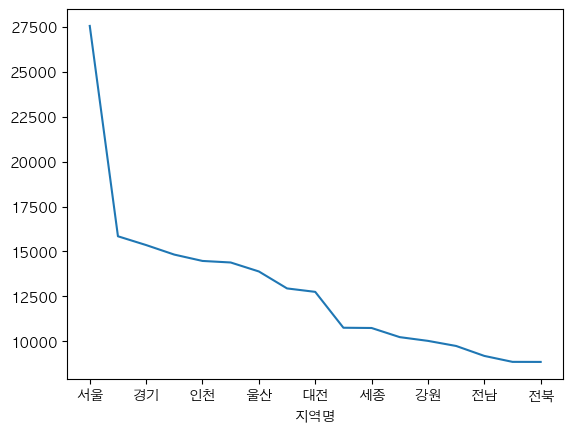

In [37]:
# 지역명으로 분양가격의 평균을 구하고 선그래프로 시각화 합니다.
g = df_last.groupby(["지역명"])["평당분양가격"].mean().sort_values(ascending=False)
g.plot()

<Axes: xlabel='지역명'>

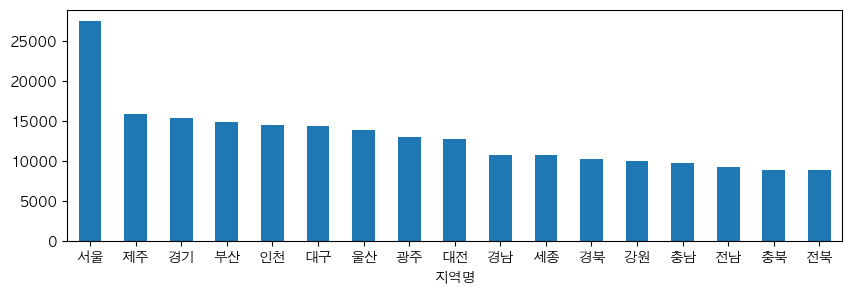

In [38]:
# 지역명으로 분양가격의 평균을 구하고 막대그래프(bar)로 시각화 합니다.
g.plot.bar(rot=0, figsize=(10, 3))


<Axes: xlabel='전용면적'>

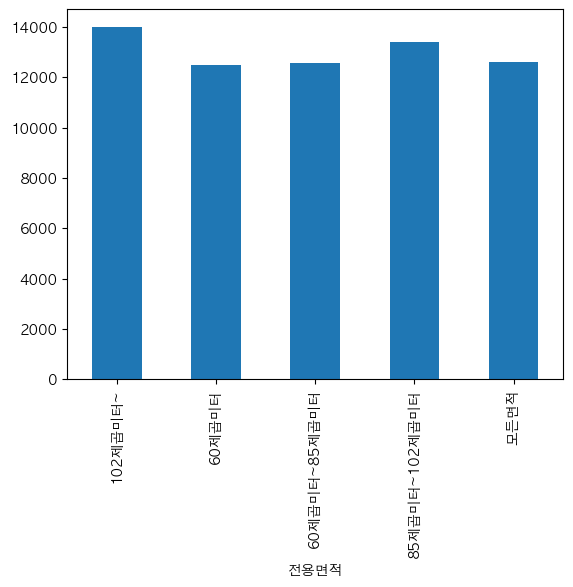

In [40]:
#전용면적으로 분양가격의 평균을 구하고 막대그래프(bar)로 시각화 합니다.
df_last.groupby(["전용면적"])["평당분양가격"].mean().plot.bar()

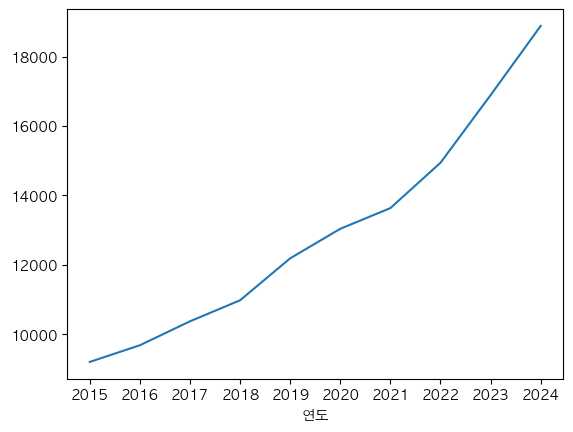

In [41]:
# 연도별 분양가격의 평균을 구하고 막대그래프(bar)로 시각화 합니다.
# 연도에 소숫점이 생기지 않게 표시하고자 한다면 ax.xaxis.set_major_locator를 사용해서 integer로 설정합니다.
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
df_last.groupby(["연도"])["평당분양가격"].mean().plot()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

<Axes: >

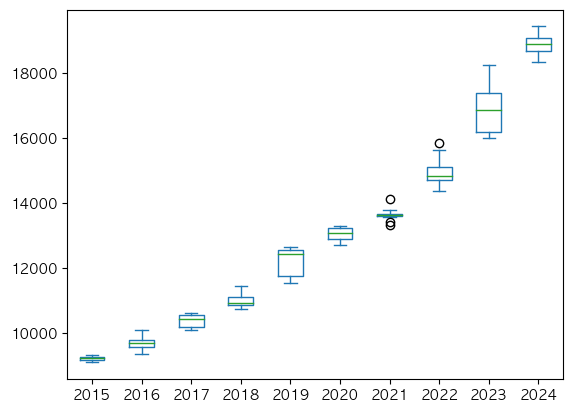

In [44]:
df_last.pivot_table(index="월", columns="연도", values="평당분양가격").plot.box()

### Seaborn 으로 시각화 해보

In [46]:
import seaborn as sns
%matplotlib inline

/var/folders/6r/c9m3dgc111dbq0x827cylmsm0000gn/T/ipykernel_3201/2453135000.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_last, x="지역명", y="평당분양가격", ci=None)


<Axes: xlabel='지역명', ylabel='평당분양가격'>

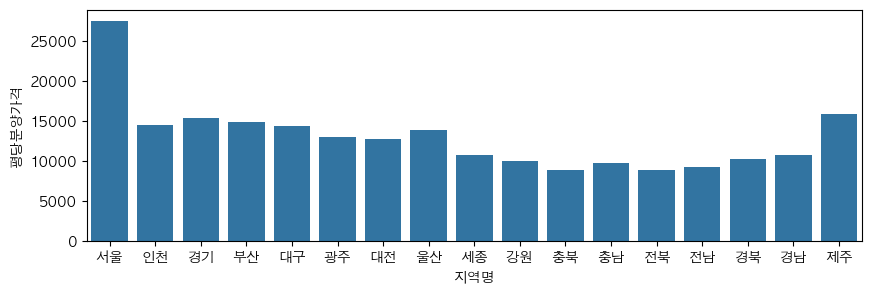

In [47]:
# barplot으로 지역별 평당분양가격을 그려봅니다.
plt.figure(figsize=(10, 3))
sns.barplot(data=df_last, x="지역명", y="평당분양가격", ci=None)

<Axes: xlabel='연도', ylabel='평당분양가격'>

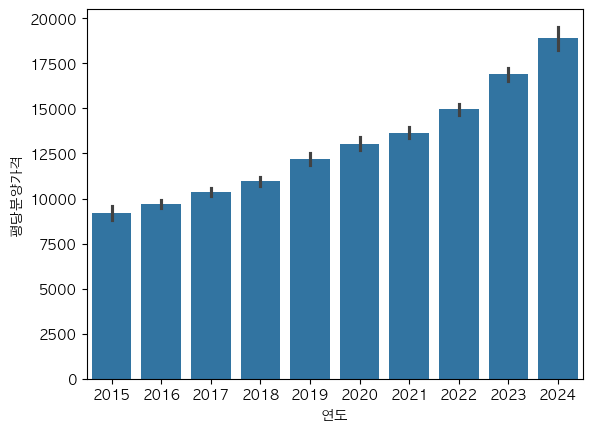

In [48]:
# barplot으로 연도별 평당분양가격을 그려봅니다.

sns.barplot(data=df_last, x="연도", y="평당분양가격")

### boxplot과 violinplot

<Axes: xlabel='연도', ylabel='평당분양가격'>

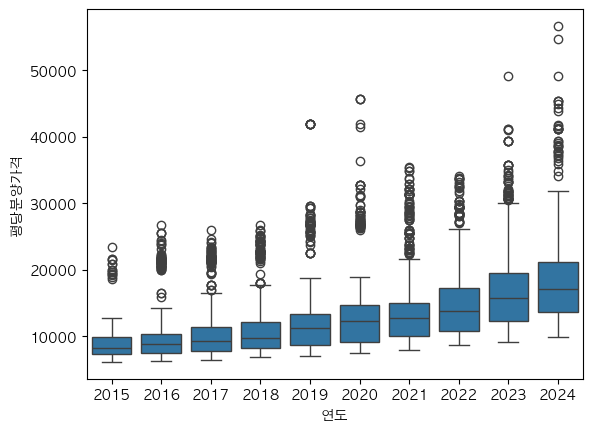

In [49]:
# 연도별 평당분양가격을 boxplot으로 그려봅니다.
# 최솟값
# 제 1사분위수
# 제 2사분위수( ), 즉 중앙값
# 제 3 사분위 수( )
# 최댓값

sns.boxplot(data=df_last, x="연도", y="평당분양가격")

<Axes: xlabel='연도', ylabel='평당분양가격'>

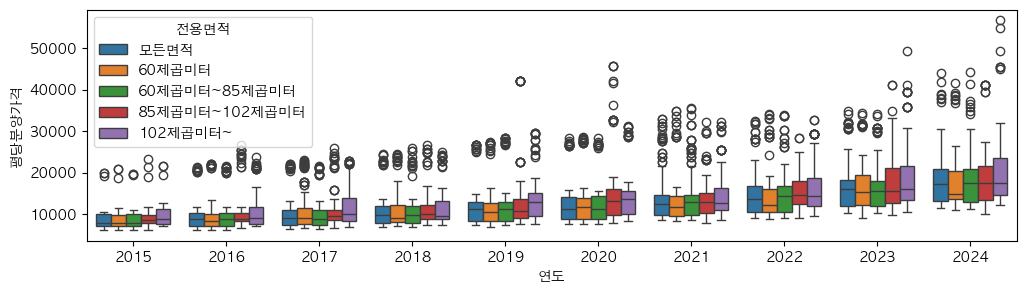

In [50]:
# hue옵션을 주어 전용면적별로 다르게 표시해 봅니다.
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_last, x="연도", y="평당분양가격", hue="전용면적")

<Axes: xlabel='연도', ylabel='평당분양가격'>

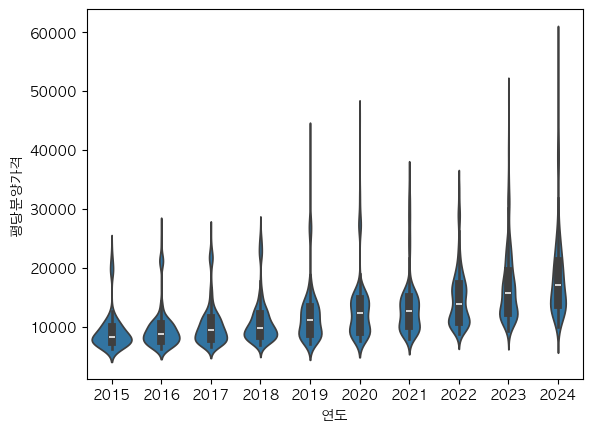

In [51]:
# 연도별 평당분양가격을 violinplot으로 그려봅니다.

sns.violinplot(data=df_last, x="연도", y="평당분양가격")

<Axes: xlabel='평당분양가격', ylabel='Density'>

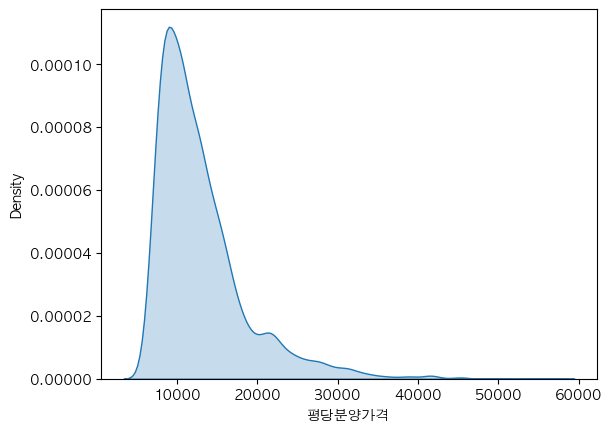

In [56]:
# 결측치가 없는 데이터에서 평당분양가격만 가져옵니다. 그리고 price라는 변수에 담습니다.
# .loc[행]
# .loc[행, 열]
price = df_last.loc[df_last["평당분양가격"].notnull(), "평당분양가격"]
# distplot으로 평당분양가격을 표현해 봅니다.

sns.kdeplot(price, fill=True)

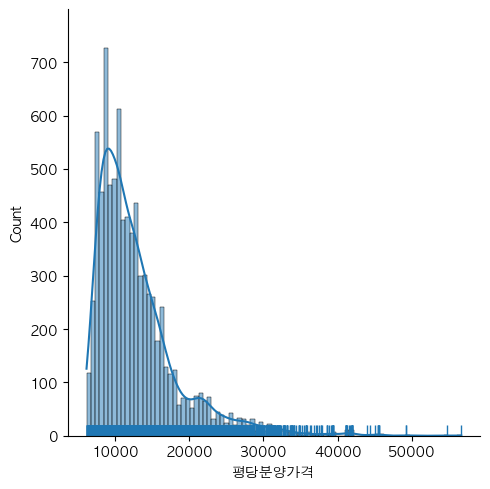

In [57]:
sns.displot(price, kde=True, rug=True)

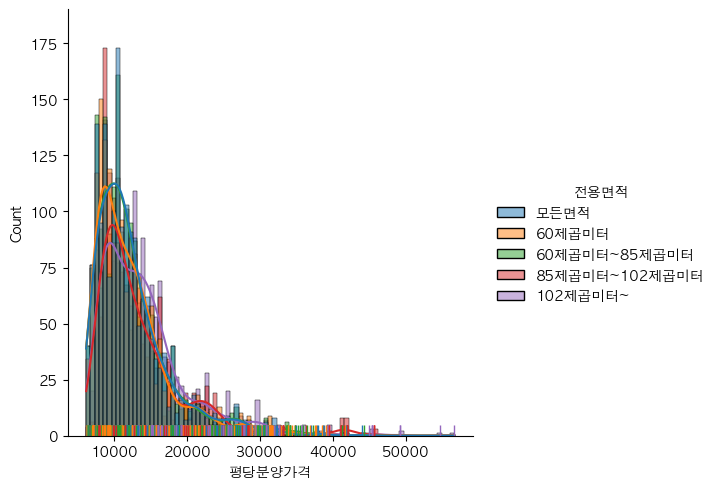

In [58]:
sns.displot(data=df_last, x="평당분양가격", kde=True, rug=True, hue="전용면적")

In [61]:
# 연도를 인덱스로, 지역명을 컬럼으로 평당분양가격을 피봇테이블로 그려봅니다.
t = pd.pivot_table(df_last, index="연도", columns="지역명", 
                   values="평당분양가격").round()
t

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
연도,,,,,,,,,,,,,,,,,
2015,7188.0,11061.0,8459.0,7464.0,7917.0,9019.0,8191.0,10377.0,20316.0,8765.0,9368.0,10976.0,6799.0,7110.0,7951.0,7690.0,6829.0
2016,7163.0,11685.0,8497.0,7753.0,9191.0,10282.0,8911.0,10744.0,21753.0,8858.0,9583.0,11099.0,6937.0,6907.0,9567.0,7958.0,7133.0
2017,7319.0,12296.0,8807.0,8288.0,9600.0,12192.0,9913.0,11638.0,21864.0,9133.0,10630.0,11672.0,7413.0,7406.0,12629.0,8157.0,7463.0
2018,8219.0,14258.0,9328.0,8681.0,9527.0,12139.0,10234.0,12890.0,23202.0,10340.0,10241.0,11882.0,7930.0,8175.0,11936.0,8202.0,8149.0
2019,8934.0,15666.0,10698.0,9050.0,12112.0,14082.0,12619.0,13538.0,28287.0,11299.0,10216.0,13250.0,8219.0,8532.0,11828.0,8749.0,7971.0
2020,10302.0,15106.0,10919.0,9998.0,13406.0,15314.0,11239.0,13353.0,29781.0,11628.0,12838.0,14983.0,9562.0,8559.0,14193.0,9139.0,8359.0
2021,10291.0,14567.0,11302.0,11227.0,13710.0,15586.0,11994.0,14318.0,29380.0,12578.0,14192.0,15774.0,9981.0,9048.0,22302.0,9861.0,8822.0
2022,11644.0,16622.0,12456.0,12018.0,15096.0,16822.0,14114.0,18167.0,29129.0,11310.0,17904.0,17342.0,10636.0,10003.0,18954.0,11730.0,10034.0
2023,13409.0,20175.0,13283.0,13025.0,17958.0,17657.0,17917.0,20471.0,33231.0,12278.0,18832.0,16151.0,11847.0,10966.0,24096.0,12581.0,11104.0


<Axes: xlabel='지역명', ylabel='연도'>

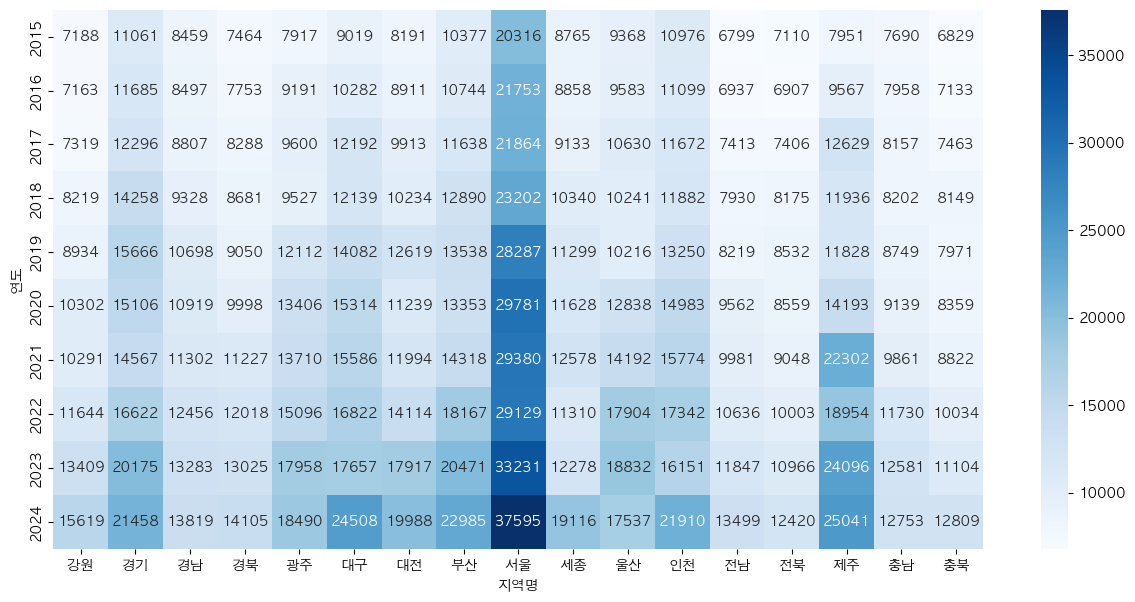

In [62]:
# 위에서 그린 피봇테이블을 히트맵으로 표현해 봅니다.
plt.figure(figsize=(15, 7))
sns.heatmap(t, cmap="Blues", annot=True, fmt=".0f")

<Axes: xlabel='연도', ylabel='지역명'>

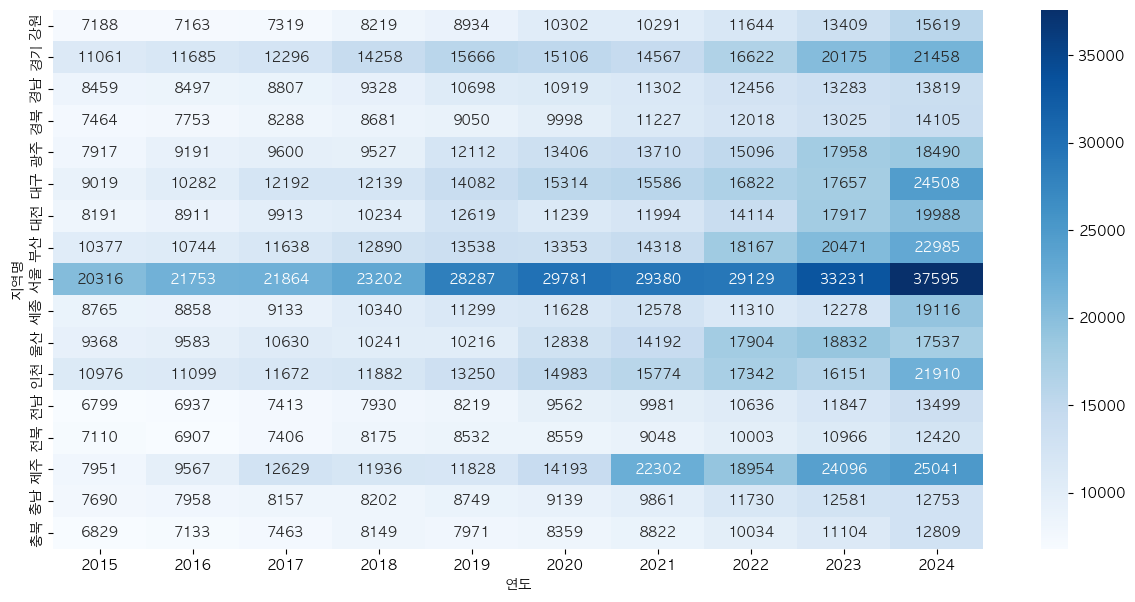

In [63]:
# transpose 를 사용하면 행과 열을 바꿔줄 수 있습니다.

t.transpose()
# 바뀐 행과 열을 히트맵으로 표현해 봅니다.

plt.figure(figsize=(15, 7))
sns.heatmap(t.T, cmap="Blues", annot=True, fmt=".0f")

In [65]:
# Groupby로 그려봅니다. 인덱스에 ["연도", "지역명"] 을 넣고 그려봅니다.
g = df_last.groupby(["연도", "지역명"])["평당분양가격"].mean().unstack().round()
g

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
연도,,,,,,,,,,,,,,,,,
2015,7188.0,11061.0,8459.0,7464.0,7917.0,9019.0,8191.0,10377.0,20316.0,8765.0,9368.0,10976.0,6799.0,7110.0,7951.0,7690.0,6829.0
2016,7163.0,11685.0,8497.0,7753.0,9191.0,10282.0,8911.0,10744.0,21753.0,8858.0,9583.0,11099.0,6937.0,6907.0,9567.0,7958.0,7133.0
2017,7319.0,12296.0,8807.0,8288.0,9600.0,12192.0,9913.0,11638.0,21864.0,9133.0,10630.0,11672.0,7413.0,7406.0,12629.0,8157.0,7463.0
2018,8219.0,14258.0,9328.0,8681.0,9527.0,12139.0,10234.0,12890.0,23202.0,10340.0,10241.0,11882.0,7930.0,8175.0,11936.0,8202.0,8149.0
2019,8934.0,15666.0,10698.0,9050.0,12112.0,14082.0,12619.0,13538.0,28287.0,11299.0,10216.0,13250.0,8219.0,8532.0,11828.0,8749.0,7971.0
2020,10302.0,15106.0,10919.0,9998.0,13406.0,15314.0,11239.0,13353.0,29781.0,11628.0,12838.0,14983.0,9562.0,8559.0,14193.0,9139.0,8359.0
2021,10291.0,14567.0,11302.0,11227.0,13710.0,15586.0,11994.0,14318.0,29380.0,12578.0,14192.0,15774.0,9981.0,9048.0,22302.0,9861.0,8822.0
2022,11644.0,16622.0,12456.0,12018.0,15096.0,16822.0,14114.0,18167.0,29129.0,11310.0,17904.0,17342.0,10636.0,10003.0,18954.0,11730.0,10034.0
2023,13409.0,20175.0,13283.0,13025.0,17958.0,17657.0,17917.0,20471.0,33231.0,12278.0,18832.0,16151.0,11847.0,10966.0,24096.0,12581.0,11104.0


<Axes: xlabel='연도', ylabel='지역명'>

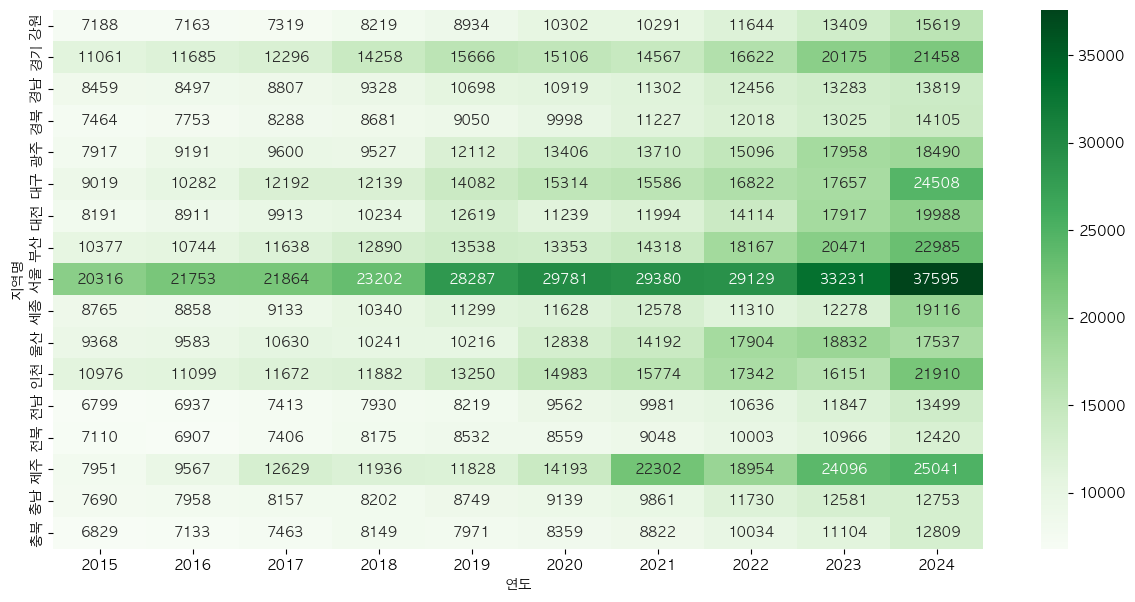

In [66]:
plt.figure(figsize=(15, 7))
sns.heatmap(g.T, annot=True, fmt=".0f", cmap="Greens")

In [72]:
# 위와 같은 그래프를 미리 연산을 하고 결과값으로 그리는 방법
# groupby 로 구하기
mean_price = df_last.groupby(["지역명"])["평당분양가격"].mean().to_frame().sort_values(by="평당분양가격", ascending=False)
mean_price

,평당분양가격
지역명,
서울,27554.911494
제주,15846.569725
경기,15357.434151
부산,14826.756250
인천,14473.649430
대구,14387.946341
울산,13888.405385
광주,12944.153812
대전,12752.592439


/var/folders/6r/c9m3dgc111dbq0x827cylmsm0000gn/T/ipykernel_3201/1835052038.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price, x=mean_price.index, y="평당분양가격", palette="Blues_r")


<Axes: xlabel='지역명', ylabel='평당분양가격'>

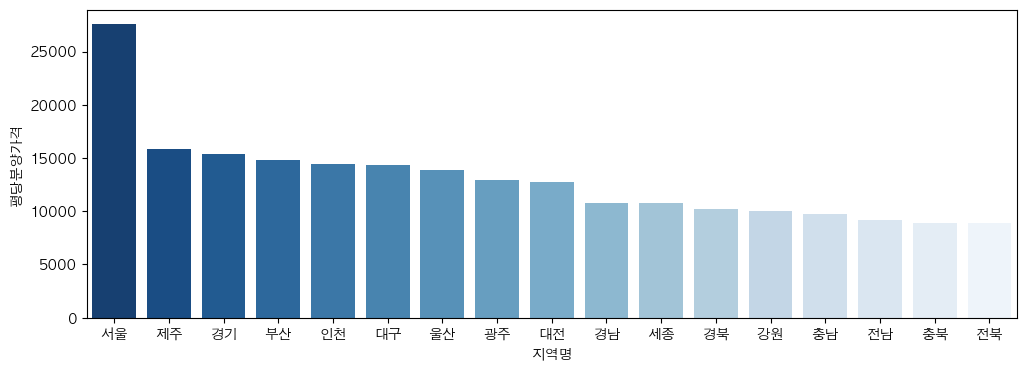

In [71]:
plt.figure(figsize=(12, 4))
sns.barplot(data=mean_price, x=mean_price.index, y="평당분양가격", palette="Blues_r")

<Axes: xlabel='지역명', ylabel='평당분양가격'>

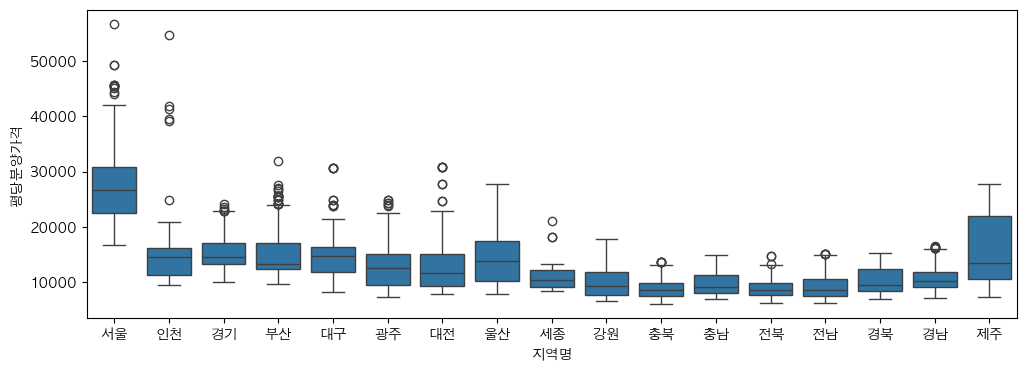

In [74]:
# boxplot 으로 지역별 평당분양가격을 그려봅니다.

plt.figure(figsize=(12, 4))
sns.boxplot(data=df_last, x="지역명", y="평당분양가격")

이 자료는 아래 사이트를 참고하였습니다.  <br>
https://github.com/corazzon/open-data-analysis-basic/blob/master/01-apt-price-output.ipynb